In [1]:
# =======================
# 1. Import Libraries
# =======================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import random

2025-11-12 16:57:46.949355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762966667.125582      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762966667.170018      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# =======================
# 2. Dataset Paths (Kaggle Version)
# =======================
train_dir = "/kaggle/input/bangladeshdeltafish1/BangladeshDeltaFish1/train"
val_dir   = "/kaggle/input/bangladeshdeltafish1/BangladeshDeltaFish1/val"
test_dir  = "/kaggle/input/bangladeshdeltafish1/BangladeshDeltaFish1/test"

In [3]:
# =======================
# 3. Output Paths (Model & Log)
# =======================
model_path = "/kaggle/working/best_model.keras"
final_model_path = "/kaggle/working/final_model.keras"
log_path = "/kaggle/working/training_log.csv"

In [4]:
# =======================
# 4. Data Augmentation Setup
# =======================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# =======================
# 5. Create Generators
# =======================
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())

# =======================
# 6. Show Counts
# =======================
print("\n IMAGE COUNTS SUMMARY")
print("-----------------------------")
print(f"Training images (after augmentation): {train_gen.samples}")
print(f"Validation images: {val_gen.samples}")
print(f"Testing images: {test_gen.samples}")

# =======================
# 7. Logic: Check Increase
# =======================
if val_gen.samples > len(os.listdir(val_dir)):
    print(" Validation images increased — unexpected!")
else:
    print(" Validation images unchanged (expected).")

if test_gen.samples > len(os.listdir(test_dir)):
    print(" Test images increased — unexpected!")
else:
    print(" Test images unchanged (expected).")

print("""
 Note:
Data augmentation does NOT create extra files.
It generates random transformations during training only for the training set.
Validation and Test sets remain unchanged.
""")

Found 1724 images belonging to 20 classes.
Found 495 images belonging to 20 classes.
Found 256 images belonging to 20 classes.

 IMAGE COUNTS SUMMARY
-----------------------------
Training images (after augmentation): 1724
Validation images: 495
Testing images: 256
 Validation images increased — unexpected!
 Test images increased — unexpected!

 Note:
Data augmentation does NOT create extra files.
It generates random transformations during training only for the training set.
Validation and Test sets remain unchanged.



In [6]:
# =======================
# 4. Class Weight (for Imbalance)
# =======================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("✅ Computed Class Weights:", class_weights)

✅ Computed Class Weights: {0: 3.747826086956522, 1: 3.3153846153846156, 2: 0.6291970802919709, 3: 1.4131147540983606, 4: 0.9577777777777777, 5: 2.155, 6: 1.486206896551724, 7: 1.1051282051282052, 8: 0.7183333333333334, 9: 2.268421052631579, 10: 0.6291970802919709, 11: 0.9472527472527472, 12: 0.7008130081300813, 13: 1.873913043478261, 14: 0.6027972027972028, 15: 2.102439024390244, 16: 0.5455696202531646, 17: 0.6201438848920864, 18: 1.4366666666666668, 19: 0.7495652173913043}


In [7]:
# =======================
# 5. Optimized CNN Model
# =======================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3), kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762966678.781729      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        10,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,275,476 (73.53 MB)

 Trainable params: 19,274,516 (73.53 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
# =======================
# 9. Callbacks
# =======================
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
csv_logger = CSVLogger(log_path, append=True)
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [9]:
# =======================
# 10. Train Model
# =======================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=60,
    callbacks=[early_stop, csv_logger, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1762966686.905021     120 service.cc:148] XLA service 0x7edc6c004880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762966686.905734     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762966687.484039     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/54 ━━━━━━━━━━━━━━━━━━━━ 10:34 12s/step - accuracy: 0.0000e+00 - loss: 9.2784

I0000 00:00:1762966693.289327     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.0739 - loss: 7.8946
Epoch 1: val_loss improved from inf to 5.85339, saving model to /kaggle/working/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 729ms/step - accuracy: 0.0746 - loss: 7.8808 - val_accuracy: 0.0808 - val_loss: 5.8534
Epoch 2/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.1786 - loss: 5.9316
Epoch 2: val_loss did not improve from 5.85339
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - accuracy: 0.1788 - loss: 5.9297 - val_accuracy: 0.0808 - val_loss: 6.8113
Epoch 3/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1642 - loss: 5.5681
Epoch 3: val_loss did not improve from 5.85339
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 414ms/step - accuracy: 0.1645 - loss: 5.5663 - val_accuracy: 0.0929 - val_loss: 8.0436
Epoch 4/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.1977 - loss: 5.3204
Epoch 4: val_loss did not improve from 5.85339
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - accuracy: 0.1979 - loss: 5.3196

In [10]:
# =======================
# 11. Save Final Model
# =======================
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

# =======================
# 12. Evaluate on Test, Val, Train
# =======================
print("\n📈 Model Evaluation Results")
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
train_loss, train_acc = model.evaluate(train_gen, verbose=1)

print(f"\n✅ Test Accuracy: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")
print(f"✅ Validation Accuracy: {val_acc*100:.2f}% | Loss: {val_loss:.4f}")
print(f"✅ Training Accuracy: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")

✅ Final model saved to: /kaggle/working/final_model.keras

📈 Model Evaluation Results
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.4714 - loss: 4.2320
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.6536 - loss: 3.9120
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 412ms/step - accuracy: 0.7709 - loss: 3.3300

✅ Test Accuracy: 55.86% | Loss: 3.9897
✅ Validation Accuracy: 64.24% | Loss: 3.8676
✅ Training Accuracy: 76.16% | Loss: 3.3650


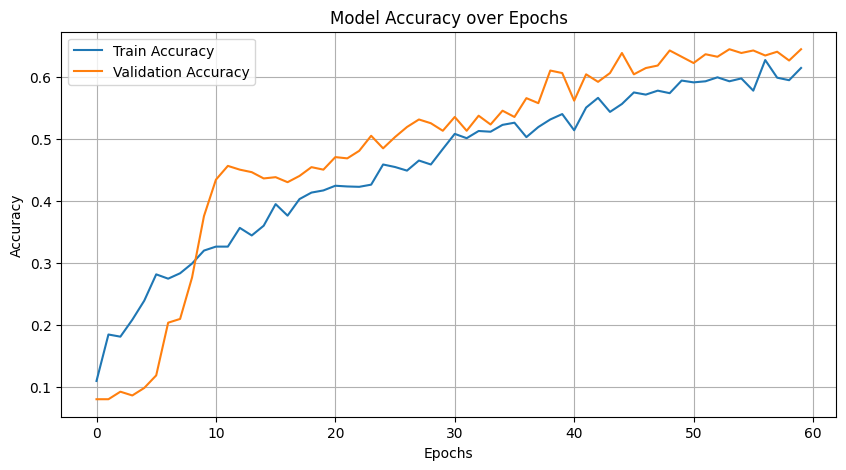

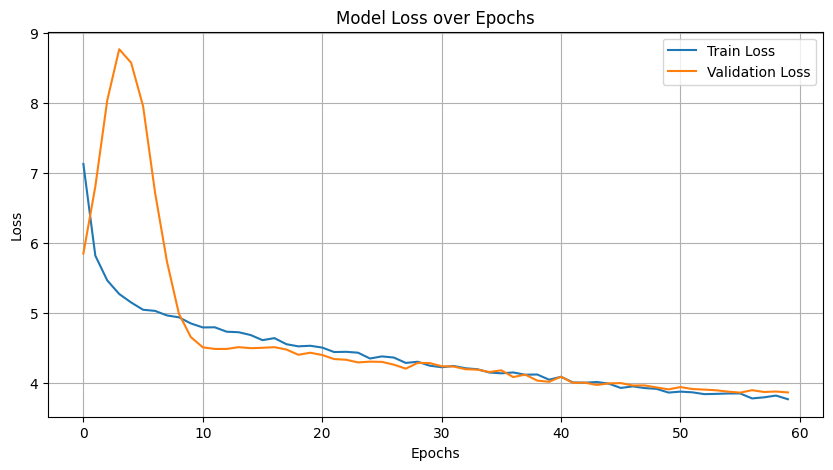

📊 Training log saved at: /kaggle/working/training_log.csv


In [11]:
# =======================
# 13. Plot Training History
# =======================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"📊 Training log saved at: {log_path}")

In [12]:
# =======================
# 14. Predictions & Metrics
# =======================
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\n📊 Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4
))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step

📊 Classification Report:

              precision    recall  f1-score   support

        Aair     0.0000    0.0000    0.0000         4
        Boal     0.7500    0.7500    0.7500         4
     Chapila     1.0000    0.4000    0.5714        20
        Foli     0.6667    0.4444    0.5333         9
       Ilish     0.5000    0.5385    0.5185        13
    KalBaush     0.3333    0.1667    0.2222         6
       Katla     0.1667    0.1111    0.1333         9
         Koi     0.6667    0.3333    0.4444        12
       Magur     0.5455    0.6667    0.6000        18
      Mrigel     0.8000    0.6667    0.7273         6
       Pabda     0.6667    0.5000    0.5714        20
      Pangas     0.6667    0.4286    0.5217        14
        Puti     0.6875    0.6111    0.6471        18
         Rui     0.2500    0.2857    0.2667         7
        Shol     0.6129    0.9048    0.7308        21
     SorPuti     0.2000    0.1667    0.1818         6
        Taki    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


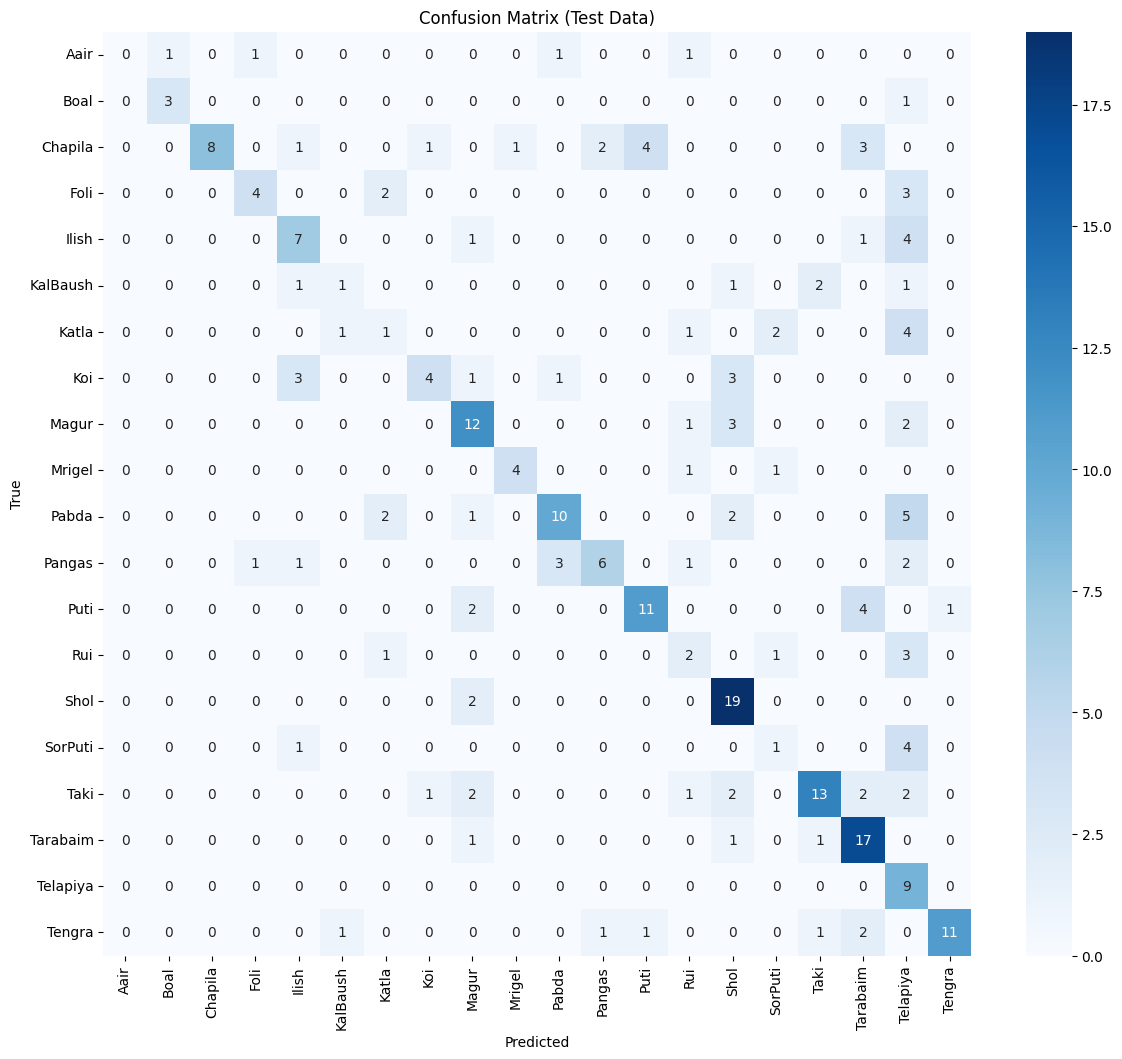

In [13]:
# =======================
# 15. Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Data)")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



📊 Per-Class Metrics:

          Precision  Recall  F1-Score
Class                                
Aair         0.0000  0.0000    0.0000
Boal         0.7500  0.7500    0.7500
Chapila      1.0000  0.4000    0.5714
Foli         0.6667  0.4444    0.5333
Ilish        0.5000  0.5385    0.5185
KalBaush     0.3333  0.1667    0.2222
Katla        0.1667  0.1111    0.1333
Koi          0.6667  0.3333    0.4444
Magur        0.5455  0.6667    0.6000
Mrigel       0.8000  0.6667    0.7273
Pabda        0.6667  0.5000    0.5714
Pangas       0.6667  0.4286    0.5217
Puti         0.6875  0.6111    0.6471
Rui          0.2500  0.2857    0.2667
Shol         0.6129  0.9048    0.7308
SorPuti      0.2000  0.1667    0.1818
Taki         0.7647  0.5652    0.6500
Tarabaim     0.5862  0.8500    0.6939
Telapiya     0.2250  1.0000    0.3673
Tengra       0.9167  0.6471    0.7586


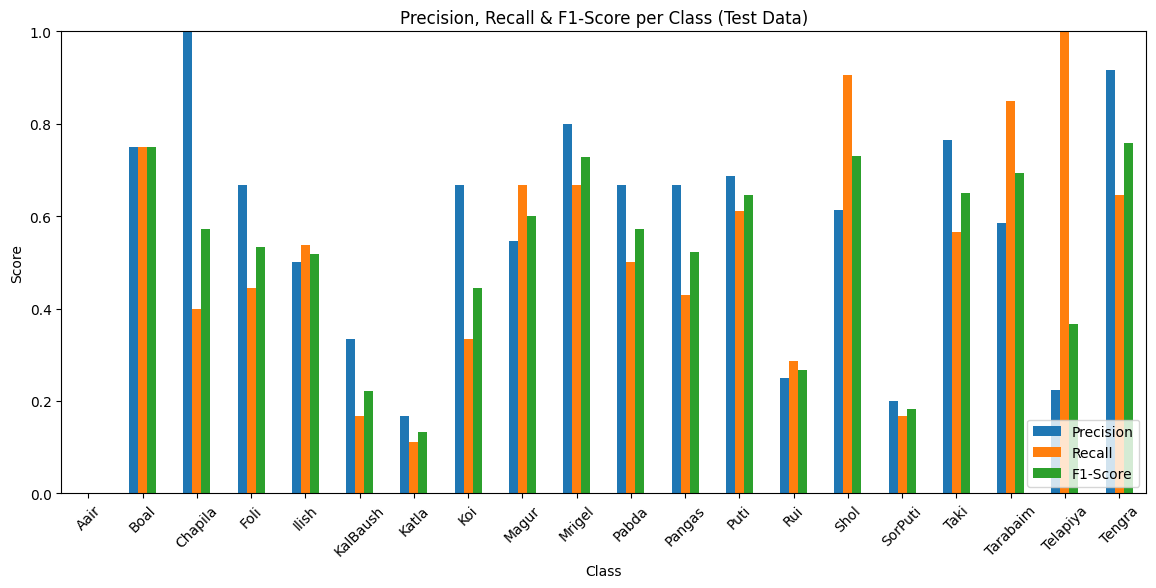

In [14]:
# =======================
# 16. Per-Class Precision, Recall, F1
# =======================
precision = precision_score(y_true, y_pred_classes, average=None)
recall    = recall_score(y_true, y_pred_classes, average=None)
f1        = f1_score(y_true, y_pred_classes, average=None)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Class')

print("\n📊 Per-Class Metrics:\n")
print(metrics_df.round(4))

metrics_df.plot(kind='bar', figsize=(14,6))
plt.title("Precision, Recall & F1-Score per Class (Test Data)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


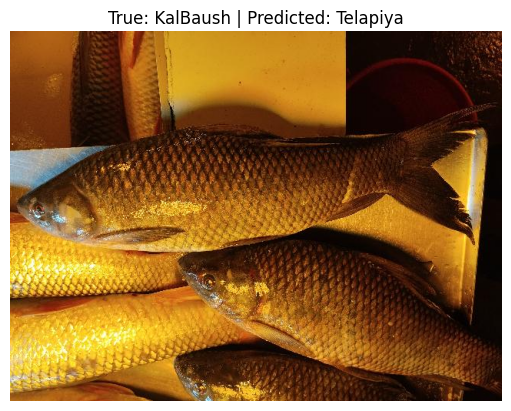

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


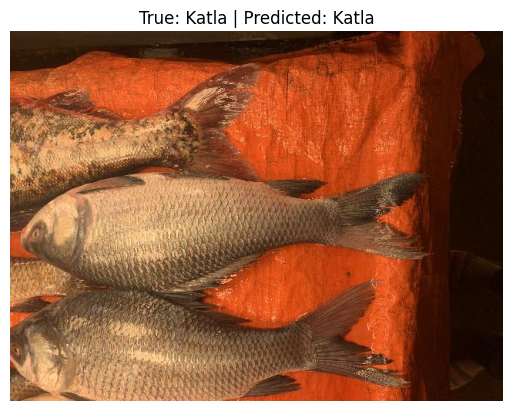

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


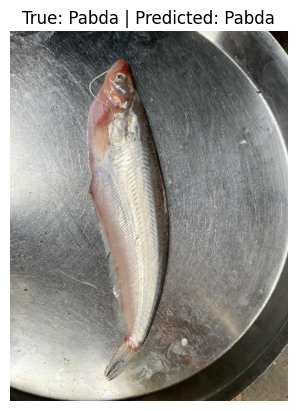

In [15]:
# =======================
# 17. Predict Random Test Images
# =======================
def predict_random_image(test_dir, model, class_names, img_size=(224,224)):
    random_class = random.choice(os.listdir(test_dir))
    class_path = os.path.join(test_dir, random_class)
    random_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_img)

    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    true_class = random_class

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis("off")
    plt.title(f"True: {true_class} | Predicted: {pred_class}")
    plt.show()

# Show 3 random predictions
for i in range(3):
    predict_random_image(test_dir, model, class_names)